<a href="https://colab.research.google.com/github/jiuShiQi97/OOP_Lab/blob/master/demo11-conditional-gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GANs

Based on the excellent tutorial [here](https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/Conditional-GAN.ipynb).

By formulating the process as a two-player game, Generative Adversarial Networks (GANs) can be very effective in generating realistic content. However, we may want to have more control over what is generated. Conditional GANs offer more control by letting us specify the *class* of output we want. Then we hand the generated content and the class it's supposed to be to the discriminator. The disciminator attempts to differentiate between the generated content of a certain class and the real content of a certain class.

The original paper that described conditional GANs is [here](https://arxiv.org/abs/1411.1784).

![](https://salu133445.github.io/dan/figs/cgan.png)


## Libaries

As always, we load lots of libraries.

In [1]:
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import os
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Data

For this demo, we will be using the MNIST data set. We can apply GANs to other datasets but the training process takes much longer. Our goal will be to supply random noise and a class label (e.g. a digit between 0 and 9) to the generator and produce an image of that particular digit.

In [2]:
# A transform to convert the images to tensor and normalize their RGB values
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])]
)

data = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

batch_size = 64
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.39MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.60MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## Helper Functions

We'll need several helper functions for training the conditional GAN. The first converts labels to one hot encoded vectors, we will use it to pass the desired label to the generator. The second will plot a grid of 10x10 images from the generator.

In [3]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [4]:
to_onehot(3)

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [5]:
def get_sample_image(G, DEVICE, n_noise=100):
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

## Architecture

We now instantiate the generator and discriminator architectures. The generator takes a random noise vector and a one hot encoded label as input and produces an image. The discriminator takes an image and a one hot encoded label as input and produces a single value between 0 and 1. The discriminator is trained to output 1 for real images and 0 for fake images. The generator is trained to fool the discriminator by outputting images that look real.

In [6]:
class Generator(nn.Module):
    def __init__(self, input_size=100, num_classes=10, image_size=28*28):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size+num_classes, 128), # auxillary dimension for label
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.network(v)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_size=28*28, num_classes=10, num_output=1):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size+num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_output),
            nn.Sigmoid(),
        )

    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.network(v)
        return y_

## Set up and Training

Now, we're ready to instantiate our models, hyperparameters, and optimizers. Since the task is so easy for MNIST, we will train for only 10 epochs. We will update the generator and discriminator in every step but often one can be trained more frequently than the other.

In [8]:
MODEL_NAME = 'ConditionalGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = Discriminator().to(DEVICE) # randomly intialized
G = Generator().to(DEVICE) # randomly initialized

max_epoch = 10
step = 0
n_noise = 100 # size of noise vector

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# We will denote real images as 1s and fake images as 0s
# This is why we needed to drop the last batch of the data loader
all_ones = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator label: real
all_zeros = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label: fake

In [9]:
images, class_labels = next(iter(data_loader))
class_labels_encoded = class_labels.view(batch_size, 1)
class_labels_encoded = to_onehot(class_labels_encoded).to(DEVICE)
print(class_labels[:10])
print(class_labels_encoded[:10])

tensor([4, 0, 9, 0, 3, 1, 0, 8, 8, 5])
tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], device='cuda:0')


In [10]:
# a directory to save the generated images
if not os.path.exists('samples'):
    os.makedirs('samples')

for epoch in range(max_epoch):
    for idx, (images, class_labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        class_labels = class_labels.view(batch_size, 1) # add singleton dimension so batch_size x 1
        class_labels = to_onehot(class_labels).to(DEVICE)
        x_outputs = D(x, class_labels) # input includes labels
        D_x_loss = criterion(x_outputs, all_ones) # Discriminator loss for real images

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, class_labels), class_labels) # input to both generator and discriminator includes labels
        D_z_loss = criterion(z_outputs, all_zeros) # Discriminator loss for fake images
        D_loss = D_x_loss + D_z_loss # Total Discriminator loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, class_labels), class_labels)
        G_loss = -1 * criterion(z_outputs, all_zeros) # Generator loss is negative disciminator loss

        G.zero_grad()
        G_loss.backward()
        G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, DEVICE, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/10, Step: 0, D Loss: 1.374887466430664, G Loss: -0.6550166010856628
Epoch: 0/10, Step: 500, D Loss: 1.1796238422393799, G Loss: -0.542475700378418
Epoch: 1/10, Step: 1000, D Loss: 1.2310326099395752, G Loss: -0.42796021699905396
Epoch: 1/10, Step: 1500, D Loss: 1.0806726217269897, G Loss: -0.5493006706237793
Epoch: 2/10, Step: 2000, D Loss: 1.3108172416687012, G Loss: -0.4714769721031189
Epoch: 2/10, Step: 2500, D Loss: 1.1593732833862305, G Loss: -0.5807039737701416
Epoch: 3/10, Step: 3000, D Loss: 1.242811679840088, G Loss: -0.44369786977767944
Epoch: 3/10, Step: 3500, D Loss: 1.2730896472930908, G Loss: -0.48487138748168945
Epoch: 4/10, Step: 4000, D Loss: 1.2622578144073486, G Loss: -0.707333505153656
Epoch: 4/10, Step: 4500, D Loss: 1.2141785621643066, G Loss: -0.6257791519165039
Epoch: 5/10, Step: 5000, D Loss: 1.4144117832183838, G Loss: -0.24739381670951843
Epoch: 5/10, Step: 5500, D Loss: 1.3624372482299805, G Loss: -0.42796239256858826
Epoch: 6/10, Step: 6000, D Loss

Now let's plot these images. At first, the generator just produces noise (as we expect).

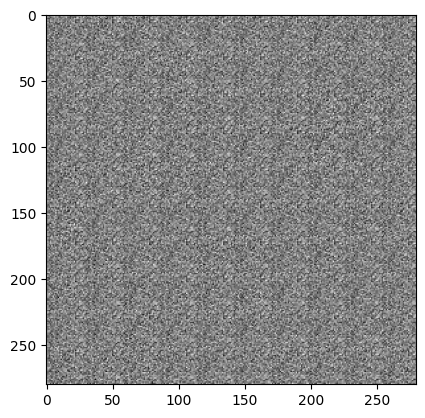

In [11]:
img = mpimg.imread('samples/ConditionalGAN_step000.jpg')
imgplot = plt.imshow(img)
plt.show()

But then it gets better.

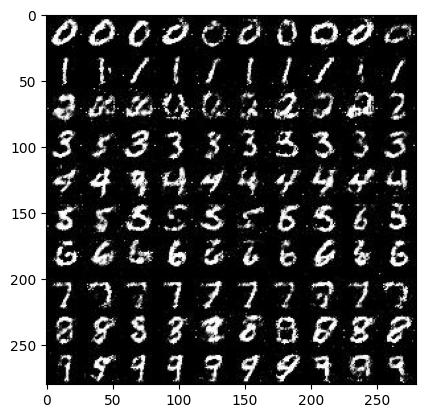

In [12]:
img = mpimg.imread('samples/ConditionalGAN_step5000.jpg')
imgplot = plt.imshow(img)
plt.show()

In fact, if we don't look too closely, we can recognize the numbers it produces.

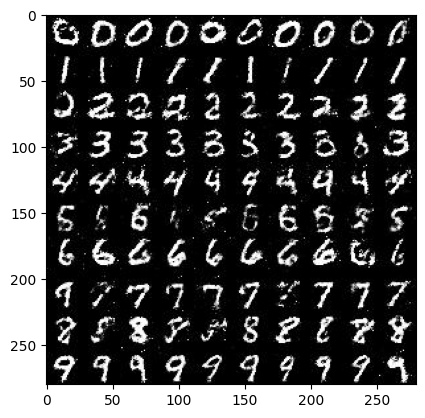

In [13]:
img = mpimg.imread('samples/ConditionalGAN_step9000.jpg')
imgplot = plt.imshow(img)
plt.show()

And by the time we're done training, even the worst images look like messy handwriting!

Epoch [1/50] | D Loss: 0.4022 | G Loss: 5.8617
Epoch [2/50] | D Loss: 0.5598 | G Loss: 4.5303
Epoch [3/50] | D Loss: 0.5787 | G Loss: 2.1412
Epoch [4/50] | D Loss: 0.6589 | G Loss: 1.8039
Epoch [5/50] | D Loss: 0.8398 | G Loss: 2.7486
Epoch [6/50] | D Loss: 0.6794 | G Loss: 1.5295
Epoch [7/50] | D Loss: 0.9617 | G Loss: 2.2788
Epoch [8/50] | D Loss: 0.8891 | G Loss: 2.8801
Epoch [9/50] | D Loss: 1.0155 | G Loss: 1.8604
Epoch [10/50] | D Loss: 1.0887 | G Loss: 1.6905
Epoch [11/50] | D Loss: 1.1793 | G Loss: 1.3212
Epoch [12/50] | D Loss: 1.2460 | G Loss: 0.9820
Epoch [13/50] | D Loss: 1.1495 | G Loss: 0.9304
Epoch [14/50] | D Loss: 1.2575 | G Loss: 1.2080
Epoch [15/50] | D Loss: 1.1296 | G Loss: 1.2618
Epoch [16/50] | D Loss: 1.2755 | G Loss: 1.0210
Epoch [17/50] | D Loss: 1.2228 | G Loss: 1.2466
Epoch [18/50] | D Loss: 1.1117 | G Loss: 1.1940
Epoch [19/50] | D Loss: 1.3307 | G Loss: 1.1934
Epoch [20/50] | D Loss: 1.2681 | G Loss: 1.2213
Epoch [21/50] | D Loss: 1.3728 | G Loss: 0.8864
E

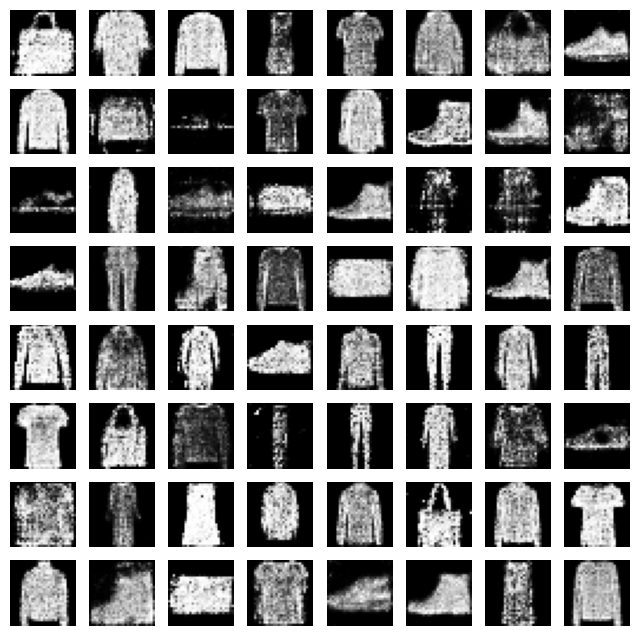

In [15]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# --- Data Preparation ---
# Transform for FashionMNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load FashionMNIST dataset
data = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset=data, batch_size=64, shuffle=True)

# --- GAN Components ---
# Generator
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Tanh()  # Output range is [-1, 1] after normalization
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)  # Reshape to image dimensions

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2, True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1))  # Flatten image to 1D

# --- Initialize Models, Optimizers, and Loss ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise_dim = 100  # Dimensionality of noise input

generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers
optim_gen = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_disc = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss Function (Binary Cross-Entropy)
loss_fn = nn.BCELoss()

# --- Training ---
epochs = 50
for epoch in range(epochs):
    for real_imgs, _ in data_loader:
        real_imgs = real_imgs.to(device)

        # Train Discriminator
        optim_disc.zero_grad()

        # Real images
        real_labels = torch.ones(real_imgs.size(0), 1).to(device)
        real_loss = loss_fn(discriminator(real_imgs), real_labels)

        # Fake images
        noise = torch.randn(real_imgs.size(0), noise_dim).to(device)
        fake_imgs = generator(noise)
        fake_labels = torch.zeros(real_imgs.size(0), 1).to(device)
        fake_loss = loss_fn(discriminator(fake_imgs.detach()), fake_labels)

        # Total Discriminator Loss
        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        optim_disc.step()

        # Train Generator
        optim_gen.zero_grad()
        fake_labels = torch.ones(real_imgs.size(0), 1).to(device)  # Fool the discriminator
        gen_loss = loss_fn(discriminator(fake_imgs), fake_labels)
        gen_loss.backward()
        optim_gen.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {disc_loss.item():.4f} | G Loss: {gen_loss.item():.4f}")

# --- Generate and Save Images ---
def save_generated_images(generator, noise_dim, filename):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(64, noise_dim).to(device)
        fake_imgs = generator(noise).cpu().view(-1, 28, 28)
    plt.figure(figsize=(8, 8))
    for i in range(64):
        plt.subplot(8, 8, i+1)
        plt.imshow(fake_imgs[i], cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    plt.show()

# Save some generated images
save_generated_images(generator, noise_dim, 'fashionmnist_generated.png')


Epoch [1/10] | D Loss: 0.2094 | G Loss: 3.3788
Epoch [2/10] | D Loss: 0.7335 | G Loss: 2.0707
Epoch [3/10] | D Loss: 0.6947 | G Loss: 2.5127
Epoch [4/10] | D Loss: 0.9972 | G Loss: 1.5035
Epoch [5/10] | D Loss: 0.9544 | G Loss: 1.2053
Epoch [6/10] | D Loss: 1.2749 | G Loss: 1.1071
Epoch [7/10] | D Loss: 1.1753 | G Loss: 1.5752
Epoch [8/10] | D Loss: 1.1835 | G Loss: 1.5243
Epoch [9/10] | D Loss: 1.1927 | G Loss: 1.4054
Epoch [10/10] | D Loss: 1.0716 | G Loss: 1.1270


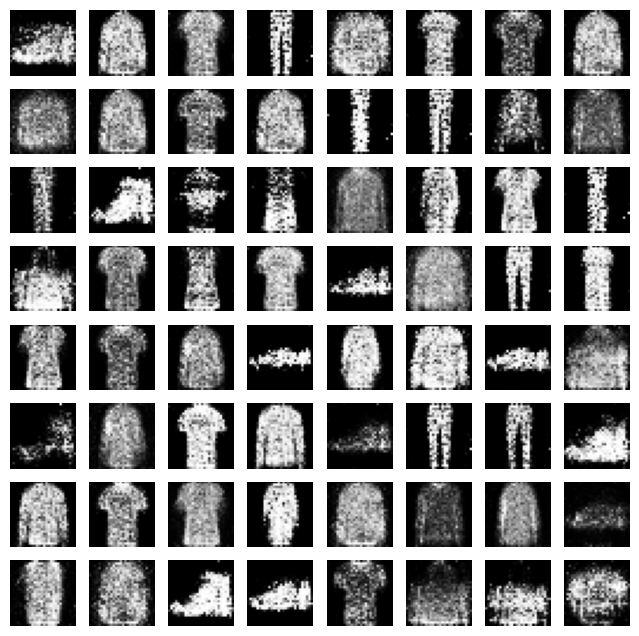

In [16]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# --- Data Preparation ---
# Transform to normalize FashionMNIST images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Load FashionMNIST dataset
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# --- GAN Components ---
# Generator
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 784),
            nn.Tanh()  # Output range [-1, 1]
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)  # Reshape to 28x28 image

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2, True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1))  # Flatten image to 1D

# --- Initialize Models, Optimizers, and Loss ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise_dim = 100  # Dimensionality of noise input

generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss Function (Binary Cross-Entropy)
loss_fn = nn.BCELoss()

# --- Training Loop ---
epochs = 10
for epoch in range(epochs):
    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Real images
        real_labels = torch.ones(real_imgs.size(0), 1).to(device)
        real_loss = loss_fn(discriminator(real_imgs), real_labels)

        # Fake images
        noise = torch.randn(real_imgs.size(0), noise_dim).to(device)
        fake_imgs = generator(noise)
        fake_labels = torch.zeros(real_imgs.size(0), 1).to(device)
        fake_loss = loss_fn(discriminator(fake_imgs.detach()), fake_labels)

        # Total Discriminator Loss
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_labels = torch.ones(real_imgs.size(0), 1).to(device)  # Fool the discriminator
        g_loss = loss_fn(discriminator(fake_imgs), fake_labels)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# --- Generate and Save Images ---
def generate_and_save_images(generator, noise_dim, filename):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(64, noise_dim).to(device)
        fake_images = generator(noise).cpu().view(-1, 28, 28)
    plt.figure(figsize=(8, 8))
    for i in range(64):
        plt.subplot(8, 8, i+1)
        plt.imshow(fake_images[i], cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    plt.show()

# Save some generated images
generate_and_save_images(generator, noise_dim, 'fashionmnist_gan_generated.png')


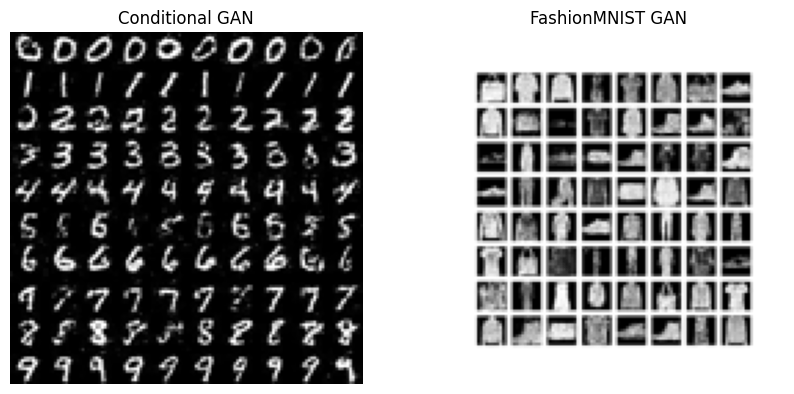

Structural Similarity Index (SSIM): -0.0289
Mean Squared Error (MSE): 69.5853


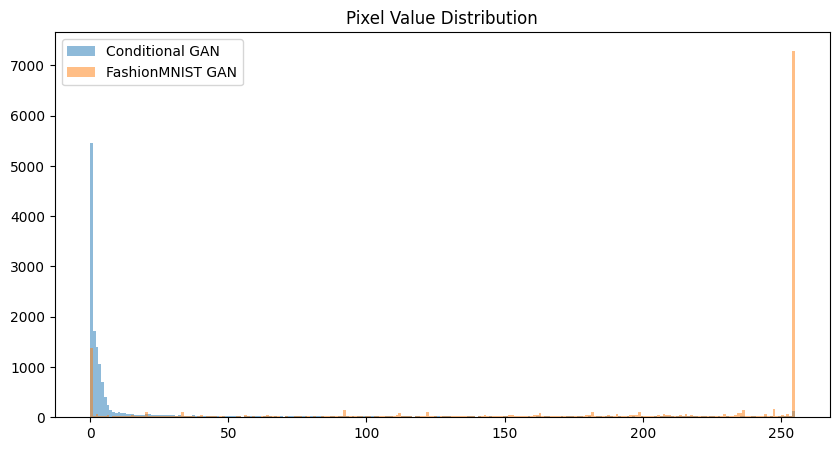

In [24]:
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import numpy as np

# --- 加载图片 ---
# 加载 Conditional GAN 的生成图片
img_conditional = Image.open('samples/ConditionalGAN_step9000.jpg').convert('L')
# 加载 FashionMNIST GAN 的生成图片
img_fashion = Image.open('fashionmnist_generated.png').convert('L')

# --- 调整尺寸为相同大小 ---
# 假设目标尺寸是 28x28（根据 FashionMNIST 的标准）
target_size = (128, 128)
img_conditional_resized = img_conditional.resize(target_size)
img_fashion_resized = img_fashion.resize(target_size)

# 转换为 NumPy 数组
img_conditional_np = np.array(img_conditional_resized)
img_fashion_np = np.array(img_fashion_resized)

# --- 显示图片 ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Conditional GAN")
plt.imshow(img_conditional_np, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("FashionMNIST GAN")
plt.imshow(img_fashion_np, cmap='gray')
plt.axis('off')
plt.show()

# --- 统计分析 ---
# 1. 计算结构相似性指数（SSIM）
similarity, _ = ssim(img_conditional_np, img_fashion_np, full=True)
print(f"Structural Similarity Index (SSIM): {similarity:.4f}")

# 2. 计算均方误差（MSE）
mse = np.mean((img_conditional_np - img_fashion_np) ** 2)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# 3. 像素分布直方图
plt.figure(figsize=(10, 5))
plt.hist(img_conditional_np.ravel(), bins=256, alpha=0.5, label="Conditional GAN")
plt.hist(img_fashion_np.ravel(), bins=256, alpha=0.5, label="FashionMNIST GAN")
plt.title("Pixel Value Distribution")
plt.legend()
plt.show()




Epoch [1/20] | D Loss: 0.4551 | G Loss: 3.3097
Epoch [2/20] | D Loss: 0.6459 | G Loss: 2.3725
Epoch [3/20] | D Loss: 0.6231 | G Loss: 2.4813
Epoch [4/20] | D Loss: 1.1701 | G Loss: 2.8249
Epoch [5/20] | D Loss: 1.1049 | G Loss: 2.0582
Epoch [6/20] | D Loss: 1.0725 | G Loss: 2.7496
Epoch [7/20] | D Loss: 1.1651 | G Loss: 2.0751
Epoch [8/20] | D Loss: 1.3663 | G Loss: 0.8027
Epoch [9/20] | D Loss: 1.1152 | G Loss: 1.0668
Epoch [10/20] | D Loss: 1.1507 | G Loss: 1.4992
Epoch [11/20] | D Loss: 1.2138 | G Loss: 1.1749
Epoch [12/20] | D Loss: 1.1089 | G Loss: 1.4178
Epoch [13/20] | D Loss: 1.2031 | G Loss: 1.3492
Epoch [14/20] | D Loss: 1.1679 | G Loss: 0.8593
Epoch [15/20] | D Loss: 1.1837 | G Loss: 1.0632
Epoch [16/20] | D Loss: 1.1971 | G Loss: 1.1642
Epoch [17/20] | D Loss: 1.1579 | G Loss: 1.6058
Epoch [18/20] | D Loss: 1.3496 | G Loss: 1.0416
Epoch [19/20] | D Loss: 1.3367 | G Loss: 1.0261
Epoch [20/20] | D Loss: 1.2953 | G Loss: 0.9434


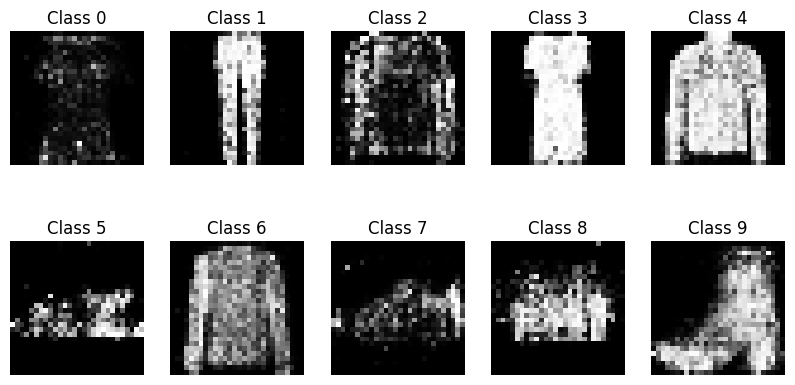

KeyboardInterrupt: 

In [29]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np
from PIL import Image

# --- 数据准备 ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # [-1, 1]
])
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
# --- Conditional GAN ---
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim, num_classes):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(noise_dim + num_classes, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        c = self.label_emb(labels)
        x = torch.cat([z, c], dim=1)
        return self.model(x).view(-1, 1, 28, 28)

class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(784 + num_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        c = self.label_emb(labels)
        x = torch.cat([img.view(img.size(0), -1), c], dim=1)
        return self.model(x)

In [31]:
# --- Standard GAN ---
class GANGenerator(nn.Module):
    def __init__(self, noise_dim):
        super(GANGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

class GANDiscriminator(nn.Module):
    def __init__(self):
        super(GANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1))

In [32]:
# --- 训练函数 ---
def train_gan(generator, discriminator, train_loader, noise_dim, epochs, is_conditional=False, num_classes=None):
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        for real_imgs, labels in train_loader:
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            if is_conditional:
                labels = labels.to(device)
                real_loss = criterion(discriminator(real_imgs, labels), real_labels)
                z = torch.randn(batch_size, noise_dim).to(device)
                fake_imgs = generator(z, labels)
                fake_loss = criterion(discriminator(fake_imgs.detach(), labels), fake_labels)
            else:
                real_loss = criterion(discriminator(real_imgs), real_labels)
                z = torch.randn(batch_size, noise_dim).to(device)
                fake_imgs = generator(z)
                fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)

            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            if is_conditional:
                g_loss = criterion(discriminator(fake_imgs, labels), real_labels)
            else:
                g_loss = criterion(discriminator(fake_imgs), real_labels)

            g_loss.backward()
            optimizer_G.step()

        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    return generator

In [34]:
# --- 生成图片函数 ---
def generate_images(generator, noise_dim, filename, is_conditional=False, num_classes=None):
    generator.eval()
    with torch.no_grad():
        if is_conditional:
            z = torch.randn(64, noise_dim).to(device)
            labels = torch.randint(0, 10, (64,)).to(device)  # 随机生成64个类别
            fake_images = generator(z, labels).cpu().view(-1, 28, 28)
        else:
            z = torch.randn(64, noise_dim).to(device)
            fake_images = generator(z).cpu().view(-1, 28, 28)

    # 显示图片，调整为8行8列
    plt.figure(figsize=(8, 8))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(fake_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

In [ ]:
# --- 比较两种GAN ---
noise_dim = 100
epochs = 50
num_classes = 10

# Conditional GAN
conditional_generator = ConditionalGenerator(noise_dim, num_classes).to(device)
conditional_discriminator = ConditionalDiscriminator(num_classes).to(device)
conditional_generator = train_gan(conditional_generator, conditional_discriminator, train_loader, noise_dim, epochs, is_conditional=True, num_classes=num_classes)
generate_images(conditional_generator, noise_dim, "fashionmnist_conditional_gan.png", is_conditional=True, num_classes=num_classes)

# Standard GAN
gan_generator = GANGenerator(noise_dim).to(device)
gan_discriminator = GANDiscriminator().to(device)
gan_generator = train_gan(gan_generator, gan_discriminator, train_loader, noise_dim, epochs, is_conditional=False)
generate_images(gan_generator, noise_dim, "fashionmnist_gan.png", is_conditional=False)

Structural Similarity Index (SSIM): 0.7363


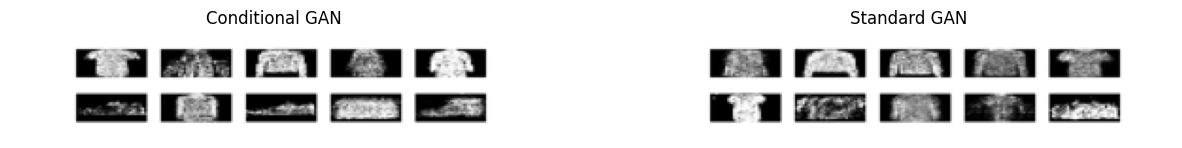

In [35]:
# --- 图片质量比较 ---
# 加载生成的图片
img_conditional = Image.open("fashionmnist_conditional_gan.png").convert('L')
img_gan = Image.open("fashionmnist_gan.png").convert('L')

# 调整尺寸一致
img_conditional_resized = img_conditional.resize((28 * 8, 28 * 8))  # 8行8列
img_gan_resized = img_gan.resize((28 * 8, 28 * 8))

# 计算统计信息
img_conditional_np = np.array(img_conditional_resized).flatten() / 255.0  # 归一化到 [0, 1]
img_gan_np = np.array(img_gan_resized).flatten() / 255.0

# 均值和标准差
real_mean, real_std = img_conditional_np.mean(), img_conditional_np.std()
fake_mean, fake_std = img_gan_np.mean(), img_gan_np.std()
mean_diff = abs(real_mean - fake_mean)
std_diff = abs(real_std - fake_std)

# 计算直方图相似度（使用交集）
hist_real, _ = np.histogram(img_conditional_np, bins=256, range=(0, 1))
hist_fake, _ = np.histogram(img_gan_np, bins=256, range=(0, 1))
hist_sim = np.sum(np.minimum(hist_real, hist_fake)) / np.sum(hist_real)

# 输出统计结果
print(f"Real images - Mean: {real_mean:.4f}, Std: {real_std:.4f}")
print(f"Fake images - Mean: {fake_mean:.4f}, Std: {fake_std:.4f}")
print(f"Mean difference: {mean_diff:.4f}")
print(f"Std difference: {std_diff:.4f}")
print(f"Histogram similarity: {hist_sim:.4f}")

# 可视化结果
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Conditional GAN")
plt.imshow(img_conditional_resized, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Standard GAN")
plt.imshow(img_gan_resized, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# --- 像素分布直方图比较 ---
def plot_pixel_distribution(img_conditional_np, img_gan_np):
    plt.figure(figsize=(10, 5))
    plt.hist(img_conditional_np, bins=256, alpha=0.5, label="Conditional GAN", color="blue")
    plt.hist(img_gan_np, bins=256, alpha=0.5, label="FashionMNIST GAN", color="orange")
    plt.title("Pixel Value Distribution")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# --- 加载并处理图片 ---
# 加载图片
img_conditional = Image.open("fashionmnist_conditional_gan.png").convert('L')
img_gan = Image.open("fashionmnist_gan.png").convert('L')

# 调整尺寸一致
img_conditional_resized = img_conditional.resize((28 * 8, 28 * 8))  # 8行8列
img_gan_resized = img_gan.resize((28 * 8, 28 * 8))

# 将像素值归一化到 [0, 1]
img_conditional_np = np.array(img_conditional_resized).flatten() / 255.0
img_gan_np = np.array(img_gan_resized).flatten() / 255.0

# --- 统计信息计算 ---
# 均值和标准差
real_mean, real_std = img_conditional_np.mean(), img_conditional_np.std()
fake_mean, fake_std = img_gan_np.mean(), img_gan_np.std()
mean_diff = abs(real_mean - fake_mean)
std_diff = abs(real_std - fake_std)

# 计算直方图相似性（基于交集）
hist_real, _ = np.histogram(img_conditional_np, bins=256, range=(0, 1))
hist_fake, _ = np.histogram(img_gan_np, bins=256, range=(0, 1))
hist_sim = np.sum(np.minimum(hist_real, hist_fake)) / np.sum(hist_real)

# 打印统计结果
print(f"Real images - Mean: {real_mean:.4f}, Std: {real_std:.4f}")
print(f"Fake images - Mean: {fake_mean:.4f}, Std: {fake_std:.4f}")
print(f"Mean difference: {mean_diff:.4f}")
print(f"Std difference: {std_diff:.4f}")
print(f"Histogram similarity: {hist_sim:.4f}")

# --- 显示像素分布直方图 ---
plot_pixel_distribution(img_conditional_np, img_gan_np)
